# Training

In [17]:
# This file will train the models.
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
import pickle

from statistics import multimode
from cmath import nan


import seaborn as sns
pd.set_option("display.max_rows", None, "display.max_columns", None)


### Functions

In [18]:
def save_model(model,name):
    filename = 'DATA/models/'+ name
    # Save the model. 
    pickle.dump(model, open(filename, 'wb')) 
def load_model(name):
    filename = 'DATA/models/'+ name 
    model = pickle.load(open(filename, 'rb'))
    return(model)

In [19]:
def logistic_regression(training):
    X_train,X_test,y_train,y_test = train_test_split(training.drop(['Protest','place', 'grievances', 'triggers', 'tactics', 'actors', 'locations', 'weapons', 'eventualities', 'curiosities', 'non_protests', 'universities'],axis = 1), training['Protest'],test_size = 0.3,random_state=7)
    # training the model
    logreg =  LogisticRegression(solver='lbfgs')
    logreg.fit(X_train,y_train)
    score = logreg.score(X_test,y_test)
    return(logreg,score)
def niave(training):
    X_train,X_test,y_train,y_test = train_test_split(training.drop(['Protest','place', 'grievances', 'triggers', 'tactics', 'actors', 'locations', 'weapons', 'eventualities', 'curiosities', 'non_protests', 'universities'],axis = 1), training['Protest'],test_size = 0.2)
    naive = GaussianNB()
    naive.fit(X_train,y_train)
    score = naive.score(X_test,y_test)
    return(naive,score)
def linearSVM(training):
    from sklearn.svm import LinearSVC
    X_train,X_test,y_train,y_test = train_test_split(training.drop(['Protest','place', 'grievances', 'triggers', 'tactics', 'actors', 'locations', 'weapons', 'eventualities', 'curiosities', 'non_protests', 'universities'],axis = 1), training['Protest'],test_size = 0.2)
    svm = LinearSVC()
    svm.fit(X_train,y_train)
    score = svm.score(X_test,y_test)
    return(svm,score)

### Main

In [20]:
### Main
training = pd.read_csv('DATA/training_data.csv')
training = training.drop('Unnamed: 0', axis = 1)
training.head(1)
log = logistic_regression(training)
print(log)
ni = niave(training)
print(ni)
lin = linearSVM(training)
print(lin)

(LogisticRegression(), 0.5623987034035657)
(GaussianNB(), 0.49635036496350365)
(LinearSVC(), 0.49878345498783455)


c:\Users\Joseph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Looking at the feature dynamics

In [21]:
# Data visualisation Tool
def charts(feature, df):
    print('\n           ____________________________ Plots of', feature, 'per Protest and noProtest: ____________________________')
    # Pie of all Data
    fig = plt.figure(figsize=(20,5))
    f1 = fig.add_subplot(131)
    cnt = df[feature].value_counts()
    g = plt.pie(cnt, labels=cnt.index, autopct='%1.1f%%', shadow=True, startangle=90)
    
    # Count Plot By Protest and noProtest
    f = fig.add_subplot(132)
    g = sns.countplot(x=feature, hue='Protest', hue_order=[1,0], data=df, ax=f)

    # Percent stacked Plot
    Protest = df[df['Protest']==1][feature].value_counts()
    noProtest = df[df['Protest']==0][feature].value_counts()
    df2 = pd.DataFrame([Protest,noProtest])
    df2.index = ['Protest','noProtest']
    df2 = df2.T
    df2 = df2.fillna(0)
    df2['Total'] = df2.Protest + df2.noProtest
    df2.Protest = df2.Protest/df2.Total
    df2.noProtest = df2.noProtest/df2.Total
    df2.drop(['Total'], axis=1, inplace=True)
    f = fig.add_subplot(133)
    df2.plot(kind='bar', stacked=True, ax=f)
    del df2, g, f, cnt, noProtest, fig

In [22]:
len(training)

2054

In [23]:
training = training.loc[((training['Protest']== 1) & (training['NuTweets'] > 20) )| (training['Protest']==0)]
training.head(10)

,Protest,NuTweets,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,average,likes,followers,retweets,replies,sub,pol,place,grievances,triggers,tactics,actors,locations,weapons,eventualities,curiosities,non_protests,universities
1,1,28,0.307692,0.384615,0.000000,0.000000,1.000000,0.230769,0.230769,0.076923,0.153846,0.076923,3.2,0.357143,4347.107143,1.178571,0.178571,0.354399,0.064104,Mangaung,['Education'],"['Court hearing', 'Working conditions']",['Gathering'],['Political Party'],['Tertiary Edu'],[],[],[],[],['Central University of Technology']
2,0,10,0.500000,1.000000,1.000000,1.000000,0.500000,0.500000,0.500000,0.500000,0.000000,0.000000,1.1,4.400000,16809.800000,0.500000,0.600000,0.315222,0.022253,Mangaung,"['Police', 'Mining', 'Values']","['Crime Event', 'Working conditions', 'Arrests']","['Disrupt', 'Lock-out', 'Gathering']",['Civic org'],"['Tertiary Edu', 'Informal area']",[],[],[],"['Taxi violence', 'Other sport', '16 Days of a...",['Central University of Technology']
3,0,11,1.000000,0.250000,0.500000,0.000000,0.250000,0.500000,0.000000,0.500000,0.250000,0.500000,1.5,1.272727,2306.727273,0.272727,0.181818,0.488799,0.126100,Mangaung,['Mining'],"['Court hearing', 'Wage disputes']","['Attack', 'Gathering']",['Political Party'],"['School', 'Court', 'Business premises']","['Police weapons', 'Crowd weapons']",[],[],['Election debates'],['Central University of Technology']
6,1,26,0.375000,0.250000,0.000000,0.125000,0.125000,1.000000,0.500000,0.500000,0.125000,0.625000,2.9,0.500000,2403.230769,0.615385,0.115385,0.336916,0.085573,Mangaung,['Education'],['Court hearing'],['Disrupt'],[],['Tertiary Edu'],[],[],['Movements'],[],['University of Pretoria']
7,0,6,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,1.000000,0.000000,0.666667,0.000000,0.7,9.000000,5720.166667,1.333333,1.833333,0.513426,0.044444,Mangaung,"['Mining', 'Electricity']",['Utility connections'],"['Disrupt', 'Gathering']",[],[],['Police weapons'],[],[],['Election campaigns'],['Central University of Technology']
9,0,13,0.000000,0.500000,1.000000,0.250000,0.000000,0.250000,0.250000,0.500000,0.250000,0.250000,1.3,1.615385,10481.538462,0.384615,0.384615,0.167448,-0.035449,Mangaung,['National govt'],"['Project begin', 'Court hearing']",['Disrupt'],['Political Party'],"['Court', 'School']",[],[],['Special Keywords'],['Other sport'],['Central University of Technology']
10,1,52,0.250000,0.416667,0.166667,0.666667,0.166667,0.916667,1.000000,0.333333,0.583333,0.083333,5.5,4.346154,7937.750000,8.000000,0.500000,0.318974,0.061985,Mangaung,['Labour related'],['Court hearing'],['March'],['Union'],['Tertiary Edu'],[],['Police attack'],['Special Keywords'],[],['Central University of Technology']
12,0,13,0.000000,0.333333,0.666667,0.333333,0.333333,1.000000,0.000000,0.333333,0.333333,1.000000,1.3,4.153846,4182.923077,2.000000,0.307692,0.327753,0.041386,Mangaung,['Mining'],[],['Disrupt'],"['Civic org', 'Political Party']",['Tertiary Edu'],['Police weapons'],[],[],['Other sport'],['Central University of Technology']
17,0,7,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,1.000000,0.000000,0.8,1.714286,7060.000000,0.428571,0.285714,0.492585,0.105306,Mangaung,"['Electricity', 'Witchcraft', 'Labour related'...","['Working conditions', 'Utility connections']","['Attack', 'Disrupt', 'Lock-out']",[],['Tertiary Edu'],['Police weapons'],[],[],[],['Central University of Technology']
18,0,6,0.000000,0.000000,0.500000,0.500000,1.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.6,0.166667,1983.833333,0.166667,0.166667,0.486111,0.083333,Mangaung,"['Services A', 'Electricity', 'National govt']",[],['Disrupt'],['Political Party'],[],[],[],[],[],['Central University of Technology']


In [24]:
NuTweets = training["NuTweets"]

In [25]:
bins = []
for i in range(0,40,5):
    bins.append(i)
for i in range(40,max(NuTweets),1000):
    bins.append(i)

In [26]:
max(NuTweets)

1695

In [27]:
training['BinTweets'] = pd.cut(training['NuTweets'],bins)


           ____________________________ Plots of BinTweets per Protest and noProtest: ____________________________


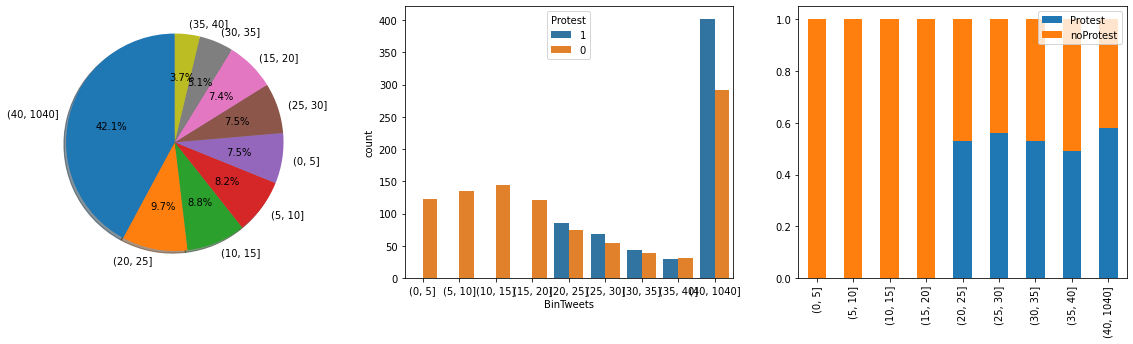

In [28]:
charts('BinTweets',training)

# autofeature selection

In [29]:
training = training.loc[((training['Protest']== 1) & (training['NuTweets'] > 20) )| (training['Protest']==0)]
training.head(1)

,Protest,NuTweets,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,average,likes,followers,retweets,replies,sub,pol,place,grievances,triggers,tactics,actors,locations,weapons,eventualities,curiosities,non_protests,universities,BinTweets
1,1,28,0.307692,0.384615,0.0,0.0,1.0,0.230769,0.230769,0.076923,0.153846,0.076923,3.2,0.357143,4347.107143,1.178571,0.178571,0.354399,0.064104,Mangaung,['Education'],"['Court hearing', 'Working conditions']",['Gathering'],['Political Party'],['Tertiary Edu'],[],[],[],[],['Central University of Technology'],"(25, 30]"


In [30]:
training.columns

Index(['Protest', 'NuTweets', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8',
       'd9', 'd10', 'average', 'likes', 'followers', 'retweets', 'replies',
       'sub', 'pol', 'place', 'grievances', 'triggers', 'tactics', 'actors',
       'locations', 'weapons', 'eventualities', 'curiosities', 'non_protests',
       'universities', 'BinTweets'],
      dtype='object')

In [33]:
# training = training.loc[((training['Protest']== 1) & (training['NuTweets'] > 20) )| (training['Protest']==0)]
training = training[['Protest', 'NuTweets', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8',
       'd9', 'd10', 'average', 'likes', 'followers', 'retweets', 'replies',
       'sub', 'pol']]
training.head(1)

,Protest,NuTweets,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,average,likes,followers,retweets,replies,sub,pol
1,1,28,0.307692,0.384615,0.0,0.0,1.0,0.230769,0.230769,0.076923,0.153846,0.076923,3.2,0.357143,4347.107143,1.178571,0.178571,0.354399,0.064104


In [47]:

X_train,X_test,y_train,y_test = train_test_split(training.drop(['Protest'],axis = 1),training['Protest'],test_size = 0.2)


In [50]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

In [52]:
cross_val_score(forest, X_train, y_train, cv = 10).mean()

0.7253189792663476

In [53]:
from sklearn.feature_selection import SelectFromModel

select_forest = SelectFromModel(estimator=forest)
new_X = select_forest.fit(X_train, y_train) 
selected_feat= X_train.columns[(select_forest.get_support())]
len(selected_feat)

print(selected_feat)

Index(['NuTweets', 'average', 'retweets'], dtype='object')


In [ ]:
#Create a function within many Machine Learning Models
def models(X_train,Y_train):
  
  #Using Logistic Regression Algorithm to the Training Set
  from sklearn.linear_model import LogisticRegression
  log = LogisticRegression(random_state = 0)
  log.fit(X_train, Y_train)  
  
  #Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm
  from sklearn.tree import DecisionTreeClassifier
  tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
  tree.fit(X_train, Y_train)

  #Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
  from sklearn.ensemble import RandomForestClassifier
  forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
  forest.fit(X_train, Y_train)
  
  # Niave
  from sklearn.naive_bayes import GaussianNB
  naive = GaussianNB()
  naive.fit(X_train, Y_train)
  
  #print model accuracy on the training data.
  print('[0]Logistic Regression Training Accuracy:', log.score(X_train, Y_train))
  print('[1]Decsion Tree Classifier Training Accuracy:', tree.score(X_train, Y_train))
  print('[2]Random Forest Classifier Training Accuracy:', forest.score(X_train, Y_train))
  print('[2]naive Classifier Training Accuracy:', naive.score(X_train, Y_train))
  
  return log, tree, forest

In [ ]:
def logistic_regression(training):
    X_train,X_test,y_train,y_test = train_test_split(training.drop(['Protest','place', 'grievances', 'triggers', 'tactics', 'actors', 'locations', 'weapons', 'eventualities', 'curiosities', 'non_protests', 'universities'],axis = 1), training['Protest'],test_size = 0.3,random_state=7)
    # training the model

def niave(training):
    X_train,X_test,y_train,y_test = train_test_split(training.drop(['Protest','place', 'grievances', 'triggers', 'tactics', 'actors', 'locations', 'weapons', 'eventualities', 'curiosities', 'non_protests', 'universities'],axis = 1), training['Protest'],test_size = 0.2)
    naive = GaussianNB()
    naive.fit(X_train,y_train)
    score = naive.score(X_test,y_test)
    return(naive,score)
def linearSVM(training):
    from sklearn.svm import LinearSVC
    X_train,X_test,y_train,y_test = train_test_split(training.drop(['Protest','place', 'grievances', 'triggers', 'tactics', 'actors', 'locations', 'weapons', 'eventualities', 'curiosities', 'non_protests', 'universities'],axis = 1), training['Protest'],test_size = 0.2)
    svm = LinearSVC()
    svm.fit(X_train,y_train)
    score = svm.score(X_test,y_test)
    return(svm,score)